In [36]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from torch.amp import autocast, GradScaler

#############################################
# Utility functions for FFT and iFFT
#############################################
def complex_fft2(x):
    # x: [B, 2, H, W] with (real, imag) in channels.
    real = x[:, 0, :, :]
    imag = x[:, 1, :, :]
    x_complex = torch.complex(real, imag)
    X_complex = torch.fft.fft2(x_complex, norm='ortho')
    return torch.stack([X_complex.real, X_complex.imag], dim=1)

def complex_ifft2(X):
    X_complex = torch.complex(X[:, 0, :, :], X[:, 1, :, :])
    x_complex = torch.fft.ifft2(X_complex, norm='ortho')
    return torch.stack([x_complex.real, x_complex.imag], dim=1)

#############################################
# Model definitions (DownBlock, UpBlock, UNet, DDIM)
#############################################
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        return x_conv, x_down

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x, skip):
        x = self.up(x)
        diffH = skip.size(2) - x.size(2)
        diffW = skip.size(3) - x.size(3)
        if diffH > 0 or diffW > 0:
            x = F.pad(x, (0, diffW, 0, diffH), mode='constant', value=0)
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=2, features=[64, 128, 256, 512]):
        super().__init__()
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        prev_channels = in_channels
        for f in features:
            self.down_blocks.append(DownBlock(prev_channels, f))
            prev_channels = f
        reversed_feats = list(reversed(features))
        for i in range(len(reversed_feats) - 1):
            self.up_blocks.append(UpBlock(reversed_feats[i], reversed_feats[i+1]))
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    def forward(self, x, t=None, cond=None):
        if cond is not None:
            x = torch.cat([x, cond], dim=1)
        skip_connections = []
        out = x
        for down in self.down_blocks:
            skip, out = down(out)
            skip_connections.append(skip)
        bottom = skip_connections[-1]
        skip_connections = skip_connections[:-1]
        up_out = bottom
        for i, up in enumerate(self.up_blocks):
            skip_i = skip_connections[-(i+1)]
            up_out = up(up_out, skip_i)
        return self.final_conv(up_out)

class DDIM(nn.Module):
    def __init__(self, unet, timesteps=1000, beta_start=1e-4, beta_end=0.02, schedule="linear", device='cpu'):
        super().__init__()
        self.unet = unet.to(device)
        self.timesteps = timesteps
        self.device = device
        if schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        elif schedule == "cosine":
            self.betas = self._cosine_beta_schedule(timesteps).to(device)
        else:
            raise ValueError(f"Unknown schedule: {schedule}")
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), self.alphas_cumprod[:-1]])
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        
    def _cosine_beta_schedule(self, timesteps, warmup_frac=0.02):
        warmup_steps = int(timesteps * warmup_frac)
        steps = torch.arange(timesteps + 1, dtype=torch.float64, device=self.device)
        s = 0.008
        alphas_cumprod_full = torch.cos(((steps / timesteps) + s) / (1 + s) * (torch.pi / 2))**2
        alphas_cumprod_full = alphas_cumprod_full / alphas_cumprod_full[0]
        if warmup_steps > 0:
            alpha_end_warmup = alphas_cumprod_full[warmup_steps]
            warmup_range = torch.linspace(1.0, alpha_end_warmup, warmup_steps + 1, device=self.device)
            alphas_cumprod_full[:warmup_steps+1] = warmup_range
        betas = 1 - (alphas_cumprod_full[1:] / alphas_cumprod_full[:-1])
        return betas.float()
        
    def forward_diffusion(self, x_start, t):
        noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        x_t = sqrt_alpha * x_start + sqrt_one_minus_alpha * noise
        return x_t, noise
        
    def forward(self, x, t, cond=None):
        return self.unet(x, t, cond=cond)
        
    def enforce_data_consistency_multicoil(self, x_pred, x_measured_k, mask):
        """
        Enforces data consistency for multi-coil data.
        x_pred:       [B, kx, ky, 2, coil] (image domain)
        x_measured_k: [B, kx, ky, 2, coil] (measured k-space)
        mask:         [B, kx, ky, 1, coil] (or with 2 in 4th dim)
        """
        B, KX, KY, two, n_coils = x_pred.shape
        if mask.shape[3] == 1:
            mask = mask.repeat(1, 1, 1, 2, 1)
        updated_coils = []
        for c in range(n_coils):
            real_pred = x_pred[:, :, :, 0, c]
            imag_pred = x_pred[:, :, :, 1, c]
            pred_complex = torch.complex(real_pred, imag_pred)
            X_coil_pred = torch.fft.fft2(pred_complex, dim=(1,2), norm='ortho')
            real_meas = x_measured_k[:, :, :, 0, c]
            imag_meas = x_measured_k[:, :, :, 1, c]
            X_coil_meas = torch.complex(real_meas, imag_meas)
            coil_mask = mask[:, :, :, :, c]
            if coil_mask.shape[3] == 2:
                coil_mask = coil_mask[:, :, :, 0]
            coil_mask = coil_mask.float().clamp(0, 1)
            X_coil_updated = X_coil_pred * (1 - coil_mask) + X_coil_meas * coil_mask
            x_coil_updated = torch.fft.ifft2(X_coil_updated, dim=(1,2), norm='ortho')
            updated_coils.append(torch.stack([x_coil_updated.real, x_coil_updated.imag], dim=3))
        x_pred_dc = torch.stack(updated_coils, dim=4)
        return x_pred_dc
        
    def reverse_diffusion(self, x_t, t, x_measured_k=None, mask=None, eta=0):
        cond = None
        if (x_measured_k is not None) and (mask is not None):
            cond = None
        pred_noise = self.unet(x_t, t, cond=cond)
        alpha = self.alphas[t][:, None, None, None]
        alpha_cumprod = self.alphas_cumprod[t][:, None, None, None]
        alpha_cumprod_prev = self.alphas_cumprod_prev[t][:, None, None, None]
        eps = 1e-8
        pred_x0 = (x_t - torch.sqrt(1 - alpha_cumprod) * pred_noise) / (torch.sqrt(alpha_cumprod) + eps)
        pred_x0 = torch.clamp(pred_x0, -1, 1)
        pred_mean = torch.sqrt(alpha_cumprod_prev) * pred_x0 + torch.sqrt(1 - alpha_cumprod_prev) * pred_noise
        if eta > 0:
            noise = torch.randn_like(x_t)
            sigma = eta * torch.sqrt(self.posterior_variance[t])[:, None, None, None]
            pred_mean = pred_mean + sigma * noise
        if (x_measured_k is not None) and (mask is not None):
            pred_mean = self.enforce_data_consistency_multicoil(
                x_pred=pred_mean,
                x_measured_k=x_measured_k,
                mask=mask
            )
        return pred_mean
        
    def sample(self, shape, x_measured_k=None, mask=None, eta=0):
        x_t = torch.randn(shape, device=self.device)
        for timestep in reversed(range(self.timesteps)):
            t_tensor = torch.full((shape[0],), timestep, device=self.device, dtype=torch.long)
            x_t = self.reverse_diffusion(x_t, t_tensor, x_measured_k=x_measured_k, mask=mask, eta=eta)
        return x_t

In [37]:
class MRIDataset(Dataset):
    def __init__(self, folder, transform=None, eps=1e-9):
        self.folder = folder
        self.filenames = sorted([f for f in os.listdir(folder) if f.endswith('.pt')])
        self.transform = transform
        self.eps = eps
    def __len__(self):
        return len(self.filenames)
    def __getitem__(self, idx):
        filepath = os.path.join(self.folder, self.filenames[idx])
        sample = torch.load(filepath)
        if sample.ndim != 4:
            raise ValueError(f"Expected sample.ndim=4 ([kx, ky, 2, coil]), got {sample.ndim}.")
        if sample.shape[2] != 2:
            raise ValueError(f"Expected sample.shape[2]==2, got {sample.shape[2]}.")
        if self.transform is not None:
            sample = self.transform(sample)
        max_val = sample.abs().max()
        if max_val > self.eps:
            sample = sample / max_val
        return sample

def pad_collate_fn(batch, global_max_channels):
    new_batch = []
    for sample in batch:
        if sample.shape[2] != 2:
            if sample.shape[2] > 2:
                sample = sample[:, :, :2, :]
            else:
                pad_channels = 2 - sample.shape[2]
                sample = F.pad(sample, (0, pad_channels))
        new_batch.append(sample)
    batch = new_batch
    max_kx = max(s.shape[0] for s in batch)
    max_ky = max(s.shape[1] for s in batch)
    padded_batch = []
    for sample in batch:
        kx, ky, two, coil = sample.shape
        if coil < global_max_channels:
            pad_coil = global_max_channels - coil
            sample = F.pad(sample, (0, pad_coil))
        elif coil > global_max_channels:
            sample = sample[..., :global_max_channels]
        padded = torch.zeros(max_kx, max_ky, 2, global_max_channels, dtype=sample.dtype)
        padded[:kx, :ky, :, :] = sample
        padded_batch.append(padded)
    return torch.stack(padded_batch, dim=0)

def compute_global_max_channels(data_folder):
    max_coil = 0
    for fname in os.listdir(data_folder):
        if not fname.endswith('.pt'):
            continue
        path = os.path.join(data_folder, fname)
        data = torch.load(path)
        if data.ndim != 4:
            raise ValueError(f"File {fname}: expected 4D [kx, ky, 2, coil], got {data.ndim}.")
        if data.shape[2] != 2:
            raise ValueError(f"File {fname}: expected data.shape[2]==2, got {data.shape[2]}.")
        coil_dim = data.shape[3]
        if coil_dim > max_coil:
            max_coil = coil_dim
    return max_coil


In [40]:
def train_diffusion_model_with_dc(
    data_folder,
    num_epochs=10,
    lr=1e-4,
    timesteps=1000,
    batch_size=2,
    schedule="linear",
    beta_start=1e-4,
    beta_end=0.02,
    checkpoint_dir=None,
    device=None,
    final_model_path=None,
    loss_function="mse",
    alpha=0.5,
    weight_decay=1e-5
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    torch.autograd.set_detect_anomaly(True)
    dataset = MRIDataset(data_folder)
    total_len = len(dataset)
    train_size = int(0.75 * total_len)
    val_size = int(0.15 * total_len)
    leftover_size = total_len - (train_size + val_size)
    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, leftover_size])
    global_max_channels = 76  # or compute_global_max_channels(data_folder)
    
    print("Global_max_channels computed:", global_max_channels)
    collate_fn = lambda batch: pad_collate_fn(batch, global_max_channels)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    unet = UNet(
        in_channels=2 * global_max_channels,
        out_channels=2 * global_max_channels,
        features=[64, 128, 256],
    ).to(device)
    ddim = DDIM(
        unet=unet,
        timesteps=timesteps,
        beta_start=beta_start,
        beta_end=beta_end,
        schedule=schedule,
        device=device
    )
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()
    
    def combined_loss(pred, target, alpha=alpha):
        return alpha * l1_criterion(pred, target) + (1 - alpha) * mse_criterion(pred, target)
    if loss_function.lower() == "mse":
        criterion = mse_criterion
    elif loss_function.lower() == "l1":
        criterion = l1_criterion
    elif loss_function.lower() == "combined":
        criterion = lambda p, t: combined_loss(p, t, alpha=alpha)
    else:
        raise ValueError(f"Unknown loss_function: {loss_function}.")
        
    optimizer = optim.Adam(ddim.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = GradScaler()
    
    def estimate_x0_from_xt(x_t, pred_noise, t_indices):
        alpha_cum = ddim.alphas_cumprod[t_indices].view(-1, 1, 1, 1)
        sqrt_alpha_cum = torch.sqrt(alpha_cum.clamp(min=1e-8))
        sqrt_one_minus_alpha = torch.sqrt(1.0 - alpha_cum)
        return (x_t - sqrt_one_minus_alpha * pred_noise) / (sqrt_alpha_cum + 1e-8)
        
    for epoch in range(num_epochs):
        ddim.train()
        train_loss_sum = 0.0
        
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}")):
            B, KX, KY, two, coil = batch.shape
            batch_4d = batch.permute(0, 3, 4, 1, 2).reshape(B, 2 * coil, KX, KY).to(device)
            gt_image_4d = batch_4d
            B_, c_, H, W_ = gt_image_4d.shape
            coil_ = c_ // 2
            gt_image_5d = gt_image_4d.reshape(B_, 2, coil_, H, W_).permute(0, 3, 4, 1, 2)
            x_measured_k_5d = gt_image_5d.clone()
            
            for c_idx in range(coil_):
                real_part = x_measured_k_5d[..., 0, c_idx]
                imag_part = x_measured_k_5d[..., 1, c_idx]
                coil_complex = torch.complex(real_part, imag_part)
                X_coil = torch.fft.fft2(coil_complex, dim=(1, 2), norm='ortho')
                x_measured_k_5d[..., 0, c_idx] = X_coil.real
                x_measured_k_5d[..., 1, c_idx] = X_coil.imag
            # For validation, use a fixed random seed so that the mask is more stable.
            torch.manual_seed(42)
            mask_2d = (torch.rand(H, W_, device=device) < 0.3)
            torch.manual_seed(torch.initial_seed())  # reset to random
            mask_5d = mask_2d[None, ..., None, None].repeat(B_, 1, 1, 1, coil_)
            mask_5d = mask_5d.repeat(1, 1, 1, 2, 1)
            x_measured_k_5d = x_measured_k_5d * mask_5d
            t = torch.randint(0, timesteps, (B,), device=device).long()
            with autocast(device_type='cuda', dtype=torch.float16):
                x_t, true_noise = ddim.forward_diffusion(gt_image_4d, t)
                pred_noise_4d = ddim(x_t, t, cond=None)
                pred_x0_4d = estimate_x0_from_xt(x_t, pred_noise_4d, t)
                pred_x0_5d = pred_x0_4d.reshape(B, 2, coil, KX, KY).permute(0, 3, 4, 1, 2)
                pred_x0_dc_5d = ddim.enforce_data_consistency_multicoil(
                    x_pred=pred_x0_5d,
                    x_measured_k=x_measured_k_5d,
                    mask=mask_5d
                )
                pred_x0_dc_4d = pred_x0_dc_5d.permute(0, 3, 4, 1, 2).reshape(B, 2 * coil, KX, KY)
                loss_noise = criterion(pred_noise_4d, true_noise)
                loss_image = criterion(pred_x0_dc_4d, gt_image_4d)
                loss = 0.5 * loss_noise + 0.5 * loss_image
            if torch.isnan(loss):
                print(f"[DEBUG] NaN loss at batch_idx={batch_idx}")
                break
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(ddim.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            train_loss_sum += loss.item()
        avg_train_loss = train_loss_sum / len(train_loader)
        ddim.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(val_loader, desc=f"[Val]   Epoch {epoch+1}/{num_epochs}")):
                B, KX, KY, two, coil = batch.shape
                batch_4d = batch.permute(0, 3, 4, 1, 2).reshape(B, 2 * coil, KX, KY).to(device)
                gt_image_4d = batch_4d
                B_, c_, H, W_ = gt_image_4d.shape
                coil_ = c_ // 2
                gt_image_5d = gt_image_4d.reshape(B_, 2, coil_, H, W_).permute(0, 3, 4, 1, 2)
                x_measured_k_5d = gt_image_5d.clone()
                for c_idx in range(coil_):
                    real_part = x_measured_k_5d[..., 0, c_idx]
                    imag_part = x_measured_k_5d[..., 1, c_idx]
                    coil_complex = torch.complex(real_part, imag_part)
                    X_coil = torch.fft.fft2(coil_complex, dim=(1, 2), norm='ortho')
                    x_measured_k_5d[..., 0, c_idx] = X_coil.real
                    x_measured_k_5d[..., 1, c_idx] = X_coil.imag
                torch.manual_seed(42)
                mask_2d = (torch.rand(H, W_, device=device) < 0.3)
                torch.manual_seed(torch.initial_seed())
                mask_5d = mask_2d[None, ..., None, None].repeat(B_, 1, 1, 1, coil_)
                mask_5d = mask_5d.repeat(1, 1, 1, 2, 1)
                x_measured_k_5d = x_measured_k_5d * mask_5d
                t = torch.randint(0, timesteps, (B,), device=device).long()
                
                with autocast(device_type='cuda', dtype=torch.float16):
                    x_t, true_noise = ddim.forward_diffusion(gt_image_4d, t)
                    pred_noise_4d = ddim(x_t, t, cond=None)
                    pred_x0_4d = estimate_x0_from_xt(x_t, pred_noise_4d, t)
                    pred_x0_5d = pred_x0_4d.reshape(B, 2, coil, KX, KY).permute(0, 3, 4, 1, 2)
                    pred_x0_dc_5d = ddim.enforce_data_consistency_multicoil(
                        x_pred=pred_x0_5d,
                        x_measured_k=x_measured_k_5d,
                        mask=mask_5d
                    )
                    pred_x0_dc_4d = pred_x0_dc_5d.permute(0, 3, 4, 1, 2).reshape(B, 2 * coil, KX, KY)
                    loss_noise = criterion(pred_noise_4d, true_noise)
                    loss_image = criterion(pred_x0_dc_4d, gt_image_4d)
                    val_loss = 0.5 * loss_noise + 0.5 * loss_image
                if torch.isnan(val_loss):
                    print(f"[DEBUG] NaN val_loss at batch_idx={batch_idx}")
                    break
                val_loss_sum += val_loss.item()
        avg_val_loss = val_loss_sum / len(val_loader)
        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        if checkpoint_dir is not None:
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_path = os.path.join(checkpoint_dir, f"ddim_epoch_{epoch+1}.pt")
            torch.save(ddim.state_dict(), checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")
        if torch.isnan(torch.tensor(avg_train_loss)):
            print("[DEBUG] Found NaN in training. Exiting epoch early.")
            break
    if final_model_path is not None:
        torch.save(ddim.state_dict(), final_model_path)
        print(f"Final model saved at: {final_model_path}")
    print("Training complete!")
    return ddim

In [ ]:
if __name__ == "__main__":
    # Path to your folder containing the .pt files
    data_folder = "mri-2"
    checkpoint_directory = "checkpoints"
    final_model_path = "models/new4_1_model.pt"

    # Train the model with the desired hyperparameters
    trained_ddim_model = train_diffusion_model_with_dc(
        data_folder,
        num_epochs=20,
        lr=1e-4,
        timesteps=1000,
        batch_size=4,
        schedule="cosine",
        beta_start=1e-4,
        beta_end=0.02,
        checkpoint_dir=checkpoint_directory,
        device=None, 
        final_model_path=final_model_path,
        loss_function="combined"
    )

Using device: cuda
Global_max_channels computed: 76


[Val]   Epoch 1/20: 100%|██████████| 229/229 [11:06<00:00,  2.91s/it]


Epoch [1/20] Train Loss: 1.262975 | Val Loss: 1.261183
Checkpoint saved: checkpoints/ddim_epoch_1.pt


[Val]   Epoch 2/20: 100%|██████████| 229/229 [10:59<00:00,  2.88s/it]


Epoch [2/20] Train Loss: 1.261122 | Val Loss: 1.261182
Checkpoint saved: checkpoints/ddim_epoch_2.pt


[Val]   Epoch 3/20: 100%|██████████| 229/229 [11:18<00:00,  2.96s/it]


Epoch [3/20] Train Loss: 1.261122 | Val Loss: 1.261182
Checkpoint saved: checkpoints/ddim_epoch_3.pt


[Val]   Epoch 4/20: 100%|██████████| 229/229 [10:52<00:00,  2.85s/it]


Epoch [4/20] Train Loss: 1.261122 | Val Loss: 1.261182
Checkpoint saved: checkpoints/ddim_epoch_4.pt


[Val]   Epoch 5/20: 100%|██████████| 229/229 [08:29<00:00,  2.23s/it]


Epoch [5/20] Train Loss: 1.261122 | Val Loss: 1.261182
Checkpoint saved: checkpoints/ddim_epoch_5.pt


[Val]   Epoch 6/20: 100%|██████████| 229/229 [11:03<00:00,  2.90s/it]


Epoch [6/20] Train Loss: 1.261122 | Val Loss: 1.261182
Checkpoint saved: checkpoints/ddim_epoch_6.pt


[Val]   Epoch 11/20: 100%|██████████| 229/229 [11:29<00:00,  3.01s/it]


Epoch [11/20] Train Loss: 1.261123 | Val Loss: 1.261184
Checkpoint saved: checkpoints/ddim_epoch_11.pt


[Val]   Epoch 12/20: 100%|██████████| 229/229 [08:56<00:00,  2.34s/it]


Epoch [12/20] Train Loss: 1.261124 | Val Loss: 1.261184
Checkpoint saved: checkpoints/ddim_epoch_12.pt


[Val]   Epoch 13/20: 100%|██████████| 229/229 [11:37<00:00,  3.04s/it]


Epoch [13/20] Train Loss: 1.261125 | Val Loss: 1.261186
Checkpoint saved: checkpoints/ddim_epoch_13.pt


[Val]   Epoch 14/20: 100%|██████████| 229/229 [11:53<00:00,  3.12s/it]


Epoch [14/20] Train Loss: 1.261126 | Val Loss: 1.261187
Checkpoint saved: checkpoints/ddim_epoch_14.pt


[Val]   Epoch 15/20: 100%|██████████| 229/229 [11:50<00:00,  3.10s/it]


Epoch [15/20] Train Loss: 1.261127 | Val Loss: 1.261188
Checkpoint saved: checkpoints/ddim_epoch_15.pt


[Val]   Epoch 16/20: 100%|██████████| 229/229 [10:06<00:00,  2.65s/it]


Epoch [16/20] Train Loss: 1.261128 | Val Loss: 1.261189
Checkpoint saved: checkpoints/ddim_epoch_16.pt


[Val]   Epoch 17/20: 100%|██████████| 229/229 [11:30<00:00,  3.02s/it]


Epoch [17/20] Train Loss: 1.261129 | Val Loss: 1.261189
Checkpoint saved: checkpoints/ddim_epoch_17.pt


[Val]   Epoch 18/20: 100%|██████████| 229/229 [11:08<00:00,  2.92s/it]


Epoch [18/20] Train Loss: 1.261129 | Val Loss: 1.261189
Checkpoint saved: checkpoints/ddim_epoch_18.pt


[Train] Epoch 19/20:   1%|          | 8/1146 [00:28<1:10:21,  3.71s/it]

In [11]:
dataset = MRIDataset("mri-2")

print("=== Checking Dataset Sample Shapes ===")
for idx in range(min(5, len(dataset))):  # just print first 5
    sample = dataset[idx]
    print(sample.shape)

=== Checking Dataset Sample Shapes ===
torch.Size([512, 208, 2, 15])
torch.Size([512, 208, 2, 15])
torch.Size([512, 208, 2, 15])
torch.Size([512, 208, 2, 15])
torch.Size([512, 208, 2, 15])


Original sample shape: torch.Size([384, 144, 2, 34])
Reshaped sample shape: torch.Size([68, 384, 144])
After padding, sample shape: torch.Size([76, 384, 144])
torch.Size([38, 384, 144])
torch.Size([1, 384, 144])


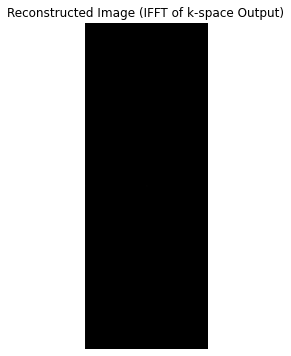

In [6]:
import torch.fft
import matplotlib.pyplot as plt

# --- Load your trained model ---
# Replace these hyperparameters with the ones you used during training.
global_max_channels = 76         # for example, if you have 15 coils (15x2=30)
features = [64, 128, 256]        # example feature sizes
timesteps = 1000                 # diffusion timesteps, etc.
schedule = "cosine"              # or "cosine"
beta_start = 1e-4
beta_end = 0.02

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = UNet(
    in_channels=global_max_channels,    # input channels should match the global maximum channels
    out_channels=global_max_channels,   # model outputs k-space data with the same channel count
    features=features,
)
ddim = DDIM(
    unet=unet,
    timesteps=timesteps,
    beta_start=beta_start,
    beta_end=beta_end,
    schedule=schedule,
    device=device
)

# Load the saved state dictionary
state_dict = torch.load("models/new3_1_model.pt", map_location=device)
ddim.load_state_dict(state_dict)
ddim.to(device)
ddim.eval()

# --- Load a sample input ---
# The sample is expected to be a .pt file with shape [kx, ky, 2, coil]
sample = torch.load("mri-2/us_0058_3T_slice0_phase34.pt", map_location=device)
print("Original sample shape:", sample.shape) 

# Permute to get [2, coil, kx, ky]
sample = sample.permute(2, 3, 0, 1)

sample = sample.reshape(-1, sample.shape[-2], sample.shape[-1])

print("Reshaped sample shape:", sample.shape)

# Pad the sample along the channel dimension if needed.
expected_channels = 76  # global_max_channels used during training
if sample.shape[0] < expected_channels:
    pad_channels = expected_channels - sample.shape[0]
    sample = F.pad(sample, (0, 0, 0, 0, 0, pad_channels))
    print("After padding, sample shape:", sample.shape)
elif sample.shape[0] > expected_channels:
    # Alternatively, crop if the sample has more channels than expected.
    sample = sample[:expected_channels, :, :]
    print("After cropping, sample shape:", sample.shape)

# Add a batch dimension: now [1, C, H, W]
sample = sample.unsqueeze(0).to(device)

# --- Run the model ---
with torch.no_grad():
    t = torch.randint(0, timesteps, (sample.size(0),), device=device).long()
    kspace_output = ddim(sample, t=t, cond=None)
    # Expected kspace_output shape: [B, global_max_channels, H, W]

# --- Convert k-space output to image domain ---
B, C, H, W = kspace_output.shape
if C % 2 != 0:
    raise ValueError("Expected an even number of channels (coil*2).")
num_coils = C // 2

# Reshape to separate coil and complex dimensions: [B, num_coils, 2, H, W]
kspace_reshaped = kspace_output.view(B, num_coils, 2, H, W)
# Convert to a complex tensor: channel 0 is real, channel 1 is imaginary
kspace_complex = torch.complex(kspace_reshaped[:, :, 0, :, :], kspace_reshaped[:, :, 1, :, :])  # [B, num_coils, H, W]
# kspace_complex = torch.fft.fftshift(kspace_complex)

print(kspace_complex[0, :,:,:].shape)

# Apply a 2D inverse FFT to get the image domain data (using orthogonal normalization)
image_coils = torch.fft.ifft2(kspace_complex, dim=(-2, -1),  norm='ortho') # kspace_complex dimension not compatible

# Compute the magnitude of each coil's image
coil_magnitudes = torch.abs(image_coils)
# Combine coils using the Sum-Of-Squares (SOS) method
reconstructed_image = torch.sqrt(torch.sum(coil_magnitudes ** 2, dim=1))  # [B, H, W]
img_min = reconstructed_image.min()
img_max = reconstructed_image.max()
reconstructed_image = (reconstructed_image - img_min) / (img_max - img_min + 1e-8)
# Visualize the first image in the batch
img_to_show = reconstructed_image[0].cpu().numpy()
print(reconstructed_image.shape)

plt.figure(figsize=(6, 6))
plt.imshow(img_to_show, cmap='gray')
plt.title("Reconstructed Image (IFFT of k-space Output)")
plt.axis("off")
plt.show()


In [7]:
if __name__ == "__main__":
    # Path to your folder containing the .pt slice/phase files
    data_folder = "mri-2"

    checkpoint_directory = "checkpoints"
    final_model_path = "models/new3_1_model.pt"

    # Train the model with desired hyperparameters
    trained_ddim_model = train_diffusion_model(
        data_folder,
        num_epochs=10,
        lr=1e-4,
        timesteps=1000,
        batch_size=4,
        schedule="cosine",
        beta_start=1e-4,
        beta_end=0.02,
        checkpoint_dir=checkpoint_directory,
        device = None, 
        final_model_path=final_model_path,
        loss_function="combined"
    )

Using device: cuda
Detected number of coils (first sample): 208
Sample shape: torch.Size([30, 512, 208])
Dataset split: 4581 train, 916 val, 612 test.
Using combined L1 + MSE loss (alpha=0.5).


[Val]   Epoch 1/10: 100%|██████████| 229/229 [10:57<00:00,  2.87s/it]


Epoch [1/10] | Train Loss: 0.783463 | Val Loss: 0.724070
Saved checkpoint: checkpoints/ddim_epoch_1.pt


[Val]   Epoch 2/10: 100%|██████████| 229/229 [11:01<00:00,  2.89s/it]


Epoch [2/10] | Train Loss: 0.692463 | Val Loss: 0.667421
Saved checkpoint: checkpoints/ddim_epoch_2.pt


[Val]   Epoch 3/10: 100%|██████████| 229/229 [08:53<00:00,  2.33s/it]


Epoch [3/10] | Train Loss: 0.646747 | Val Loss: 0.626818
Saved checkpoint: checkpoints/ddim_epoch_3.pt


[Val]   Epoch 4/10: 100%|██████████| 229/229 [11:03<00:00,  2.90s/it]


Epoch [4/10] | Train Loss: 0.617564 | Val Loss: 0.604356
Saved checkpoint: checkpoints/ddim_epoch_4.pt


[Val]   Epoch 5/10: 100%|██████████| 229/229 [11:08<00:00,  2.92s/it]


Epoch [5/10] | Train Loss: 0.598560 | Val Loss: 0.590405
Saved checkpoint: checkpoints/ddim_epoch_5.pt


[Val]   Epoch 6/10: 100%|██████████| 229/229 [07:10<00:00,  1.88s/it]


Epoch [6/10] | Train Loss: 0.580483 | Val Loss: 0.577973
Saved checkpoint: checkpoints/ddim_epoch_6.pt


IOPub message rate exceeded.       | 161/1146 [07:31<49:30,  3.02s/it] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

[Val]   Epoch 10/10: 100%|██████████| 229/229 [11:11<00:00,  2.93s/it]

Epoch [10/10] | Train Loss: 0.554453 | Val Loss: 0.549411
Saved checkpoint: checkpoints/ddim_epoch_10.pt
Final model saved at: models/new3_1_model.pt
Training complete!


Original sample shape: torch.Size([384, 144, 2, 34])
Reshaped sample shape: torch.Size([68, 384, 144])
After padding, sample shape: torch.Size([76, 384, 144])
torch.Size([38, 384, 144])
torch.Size([1, 384, 144])


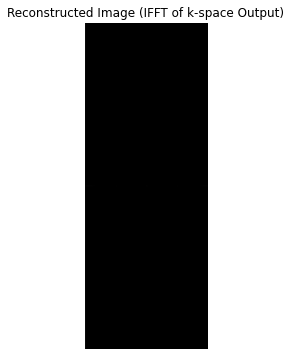

In [8]:
import torch.fft
import matplotlib.pyplot as plt

# --- Load your trained model ---
# Replace these hyperparameters with the ones you used during training.
global_max_channels = 76         # for example, if you have 15 coils (15x2=30)
features = [64, 128, 256]        # example feature sizes
timesteps = 1000                 # diffusion timesteps, etc.
schedule = "cosine"              # or "cosine"
beta_start = 1e-4
beta_end = 0.02

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = UNet(
    in_channels=global_max_channels,    # input channels should match the global maximum channels
    out_channels=global_max_channels,   # model outputs k-space data with the same channel count
    features=features,
)
ddim = DDIM(
    unet=unet,
    timesteps=timesteps,
    beta_start=beta_start,
    beta_end=beta_end,
    schedule=schedule,
    device=device
)

# Load the saved state dictionary
state_dict = torch.load("models/new3_1_model.pt", map_location=device)
ddim.load_state_dict(state_dict)
ddim.to(device)
ddim.eval()

# --- Load a sample input ---
# The sample is expected to be a .pt file with shape [kx, ky, 2, coil]
sample = torch.load("mri-2/us_0058_3T_slice0_phase34.pt", map_location=device)
print("Original sample shape:", sample.shape) 

# Permute to get [2, coil, kx, ky]
sample = sample.permute(2, 3, 0, 1)

sample = sample.reshape(-1, sample.shape[-2], sample.shape[-1])

print("Reshaped sample shape:", sample.shape)

# Pad the sample along the channel dimension if needed.
expected_channels = 76  # global_max_channels used during training
if sample.shape[0] < expected_channels:
    pad_channels = expected_channels - sample.shape[0]
    sample = F.pad(sample, (0, 0, 0, 0, 0, pad_channels))
    print("After padding, sample shape:", sample.shape)
elif sample.shape[0] > expected_channels:
    # Alternatively, crop if the sample has more channels than expected.
    sample = sample[:expected_channels, :, :]
    print("After cropping, sample shape:", sample.shape)

# Add a batch dimension: now [1, C, H, W]
sample = sample.unsqueeze(0).to(device)

# --- Run the model ---
with torch.no_grad():
    t = torch.randint(0, timesteps, (sample.size(0),), device=device).long()
    kspace_output = ddim(sample, t=t, cond=None)
    # Expected kspace_output shape: [B, global_max_channels, H, W]

# --- Convert k-space output to image domain ---
B, C, H, W = kspace_output.shape
if C % 2 != 0:
    raise ValueError("Expected an even number of channels (coil*2).")
num_coils = C // 2

# Reshape to separate coil and complex dimensions: [B, num_coils, 2, H, W]
kspace_reshaped = kspace_output.view(B, num_coils, 2, H, W)
# Convert to a complex tensor: channel 0 is real, channel 1 is imaginary
kspace_complex = torch.complex(kspace_reshaped[:, :, 0, :, :], kspace_reshaped[:, :, 1, :, :])  # [B, num_coils, H, W]
# kspace_complex = torch.fft.fftshift(kspace_complex)

print(kspace_complex[0, :,:,:].shape)

# Apply a 2D inverse FFT to get the image domain data (using orthogonal normalization)
image_coils = torch.fft.ifft2(kspace_complex, dim=(-2, -1),  norm='ortho') # kspace_complex dimension not compatible

# Compute the magnitude of each coil's image
coil_magnitudes = torch.abs(image_coils)
# Combine coils using the Sum-Of-Squares (SOS) method
reconstructed_image = torch.sqrt(torch.sum(coil_magnitudes ** 2, dim=1))  # [B, H, W]
img_min = reconstructed_image.min()
img_max = reconstructed_image.max()
reconstructed_image = (reconstructed_image - img_min) / (img_max - img_min + 1e-8)
# Visualize the first image in the batch
img_to_show = reconstructed_image[0].cpu().numpy()
print(reconstructed_image.shape)

plt.figure(figsize=(6, 6))
plt.imshow(img_to_show, cmap='gray')
plt.title("Reconstructed Image (IFFT of k-space Output)")
plt.axis("off")
plt.show()
